In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range
from sklearn.model_selection import train_test_split

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
##get the data set with clean reviews
train = pd.read_csv("clean_train_reviewsbg.csv")

In [3]:
#import the word2vec model with gensim
import gensim

In [4]:
#load word2vec
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True, limit=500000)


C:\Users\ngmat\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [5]:
#change reviews to vectors space anf get the average vector for each review
def review_to_vector(review):
    ##strip puncation
    review_array = review.split()
    wordvectors = []
    for word in review_array:
        try:
            vector = model.get_vector(word)
            wordvectors.append(vector)
        except KeyError:
            pass
    avg_word_vector = np.mean(np.array(wordvectors), axis=0)
    return avg_word_vector

In [6]:
cleanvector = []
for review in train['cleanReview']:
    cleanvector.append(review_to_vector(review))

In [7]:
X_emreviews = np.array(cleanvector, dtype=np.float)
X_emreviews.shape

(25000, 300)

In [8]:
print(X_emreviews[1])

[ 0.03917618  0.07527008  0.00668135  0.12237892 -0.05514144  0.01250296
  0.04666138 -0.04853227  0.06809974  0.06034899 -0.0264349  -0.13563843
 -0.02281494  0.04036713 -0.0774643   0.1085742   0.03467331  0.12186289
  0.01463499 -0.05926056 -0.03535689  0.07528882  0.02703972  0.00123997
  0.04615135 -0.03957943 -0.09244518  0.0536674   0.00888844 -0.00864553
 -0.06121502 -0.01299958 -0.01968536  0.03419232  0.05326509  0.0030509
  0.03214207  0.04327729  0.05265088  0.09054108  0.11198883 -0.01156807
  0.10114269  0.02941818 -0.02399211 -0.05242996 -0.06253014 -0.00025215
  0.03833618 -0.01486816 -0.01893005  0.03220692 -0.04692974  0.01528053
  0.02531347  0.02246552 -0.04301932 -0.09034767  0.02570829 -0.07500491
  0.01776581  0.09853458 -0.09504414 -0.08185279  0.0098011  -0.03730826
 -0.1026289   0.06098423 -0.02648797  0.07591248  0.0409565  -0.00612602
  0.07162933 -0.02266569 -0.12598877 -0.09535122  0.02087936  0.06742859
  0.06781578  0.10706339 -0.02486682 -0.02205276  0.

In [9]:
#train test split with features as vectors and the sentiment score 
train_features, test_features, train_labels, test_labels = train_test_split(X_emreviews, train['sentiment'], test_size = 0.33, random_state = 42)

In [11]:
#run tpot to find the best model using the parameters below
from tpot import TPOTClassifier
pipeline_optimizer = TPOTClassifier(generations=5, population_size=10, cv=5,
                                    random_state=42, verbosity=2)

In [12]:
pipeline_optimizer.fit(train_features, train_labels)

Generation 1 - Current best internal CV score: 0.8154626865671641
Generation 2 - Current best internal CV score: 0.8289552238805971
Generation 3 - Current best internal CV score: 0.8289552238805971
Generation 4 - Current best internal CV score: 0.8289552238805971
Generation 5 - Current best internal CV score: 0.8525373134328358

Best pipeline: ExtraTreesClassifier(LinearSVC(input_matrix, C=1.0, dual=False, loss=squared_hinge, penalty=l1, tol=0.1), bootstrap=False, criterion=entropy, max_features=0.9000000000000001, min_samples_leaf=12, min_samples_split=7, n_estimators=100)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=5,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=10,
        random_state=42, scoring=None, subsample=1.0, template=None,
        use_dask=False, verbosity=2, warm_start=False)

In [13]:
#predict using the best model
sen_pred_train = pipeline_optimizer.predict(train_features)
sen_pred_test = pipeline_optimizer.predict(test_features)

In [14]:
#performance score
from sklearn.metrics import accuracy_score
print('accuracy scores training set: ',accuracy_score(train_labels,sen_pred_train))
print('accuracy scores test set: ',accuracy_score(test_labels,sen_pred_test))

accuracy scores training set:  0.8783283582089553
accuracy scores test set:  0.8563636363636363


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

In [16]:
print(classification_report(test_labels, sen_pred_test)) 

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4105
           1       0.85      0.86      0.86      4145

   micro avg       0.86      0.86      0.86      8250
   macro avg       0.86      0.86      0.86      8250
weighted avg       0.86      0.86      0.86      8250



In [17]:
print(confusion_matrix(test_labels, sen_pred_test)) 

[[3492  613]
 [ 572 3573]]


In [19]:
sen_pred_test_roc = pipeline_optimizer.predict_proba(test_features)
sen_pred_test_roc_positive = sen_pred_test_roc[:, 1]

In [20]:
auc = roc_auc_score(test_labels, sen_pred_test_roc_positive)
print('AUC: %.2f' % auc)

AUC: 0.92


In [21]:
fpr, tpr, thresholds = roc_curve(test_labels, sen_pred_test_roc_positive)

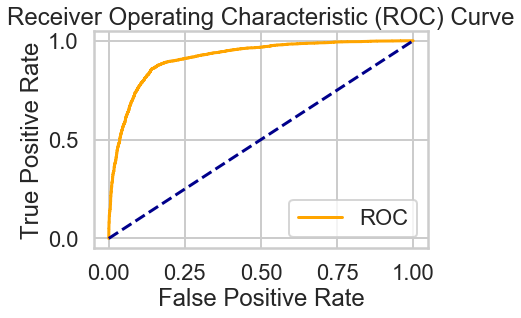

In [22]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()